In [8]:
import urllib.request
%pip install tqdm
from tqdm import tqdm #mostrar progresso
from multiprocessing import Pool #multi-processamentos, setar nº threads
import sys, os
sys.path.insert(1, '/workspaces/teo-me-why-datasus/lib')


#trabalhar com datas -> script Teo
import dttools

#convert DBC -> DBF -> CSV
%pip install simpledbf pandas tables SQLAlchemy pyreaddbc
import pyreaddbc
from simpledbf import Dbf5

Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 53.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 50.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 16.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.2/375.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [12]:
path = '../../dados/rd/dbc'
isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)

In [13]:
def get_data_uf_ano_mes(uf, ano, mes):
    url = f'ftp://ftp.datasus.gov.br/dissemin/publicos/SIHSUS/200801_/Dados/RD{uf}{ano}{mes}.dbc'
    file = f'{path}/RD{uf}{ano}{mes}.dbc'

    resp = urllib.request.urlretrieve(url, file)

def get_data_uf_ano(uf, ano, meses):
    for mes in meses:
        get_data_uf_ano_mes(uf, ano, mes)

def get_data_uf(uf, anos, meses):
    for ano in anos:
        get_data_uf_ano(uf, ano, meses)

def get_data_uf_datas(uf, datas):
    for i in tqdm(datas):
        ano, mes, dia = i.split('-')
        ano = ano[-2:]
        get_data_uf_ano_mes(uf, ano, mes)

In [14]:
ufs = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']

dt_start = '2023-01-01'
dt_end = '2023-07-01'

datas = dttools.date_range(dt_start, dt_end)
'''
for uf in ufs:
    print(uf)
    get_data_uf_datas(uf, datas)
'''

to_download = [(uf, datas) for uf in ufs]

#parallel download using 2 threads
with Pool(2) as pool:
    pool.starmap(get_data_uf_datas, to_download)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


In [16]:
print("Arquivos DBC baixados")
lst = os.listdir(path)
number_files = len(lst)
print(number_files)

Arquivos DBC baixados
189


In [17]:
def apagar_arquivos_por_extensao(dir, extensao):
    try:
        # Lista todos os arquivos no diretório
        arquivos = os.listdir(dir)

        # Filtra os arquivos pela extensão desejada
        arquivos_para_apagar = [arquivo for arquivo in arquivos if arquivo.endswith(extensao)]

        # Remove cada arquivo
        for arquivo in arquivos_para_apagar:
            caminho_arquivo = os.path.join(dir, arquivo)
            os.remove(caminho_arquivo)
            #print(f"Arquivo {arquivo} removido com sucesso.")

    except Exception as e:
        print(f"Ocorreu um erro: {e}")

In [18]:
#converter DBC -> DBF
for file in os.listdir(path):
        if file.endswith(".dbc") and ("*" not in file):
                input = f"{path}/{file}"
                output = f"{path}/{os.path.splitext(file)[0]}.dbf"

                pyreaddbc.dbc2dbf(input, output)


In [8]:
apagar_arquivos_por_extensao(path, ".dbc")

In [20]:
# converter DBF -> CSV
# Testes:
### sem Pool -> 12m para converter 6 meses
### com Pool -> parece não ter funcionado TODO: testar outras formas

path_csv = f"{path}/csv/"
isExist = os.path.exists(path_csv)
if not isExist:
   os.makedirs(path_csv)

dbf_files = []

for file in os.listdir(path):
  if file.endswith(".dbf") and ("*" not in file):
    full_path = os.path.join(path, file)
    dbf_files.append((file, full_path))

def convert_dbf_csv(file, full_path):
  dbf = Dbf5(full_path, codec='ISO-8859-1')
  dbf.to_csv(f"{path_csv}/{os.path.splitext(file)[0]}.csv")
  print(f"{file} converted to csv")

def convert_dbf_csv_wrapper(dbf_file):
    file_name, full_path = dbf_file
    convert_dbf_csv(file_name, full_path)

with Pool(2) as pool:
    pool.map(convert_dbf_csv_wrapper, dbf_files)

RDMA2301.dbf converted to csv
RDPA2302.dbf converted to csv
RDPE2302.dbf converted to csv
RDPR2306.dbf converted to csv
RDRS2302.dbf converted to csv
RDPB2304.dbf converted to csv
RDSC2301.dbf converted to csv
RDAC2305.dbf converted to csv
RDRR2302.dbf converted to csv
RDAL2305.dbf converted to csv
RDPI2301.dbf converted to csv
RDMS2303.dbf converted to csv
RDAM2303.dbf converted to csv
RDDF2307.dbf converted to csv
RDPB2303.dbf converted to csv
RDPE2301.dbf converted to csv
RDPE2305.dbf converted to csv
RDPB2306.dbf converted to csv
RDRO2301.dbf converted to csv
RDRJ2301.dbf converted to csv
RDPI2306.dbf converted to csv
RDRR2303.dbf converted to csv
RDAC2306.dbf converted to csv
RDAP2303.dbf converted to csv
RDRJ2304.dbf converted to csv
RDSP2303.dbf converted to csv
RDRO2303.dbf converted to csv
RDSE2306.dbf converted to csv
RDRN2306.dbf converted to csv
RDPR2307.dbf converted to csv
RDMA2306.dbf converted to csv
RDAM2304.dbf converted to csv
RDPE2306.dbf converted to csv
RDAP2304.d

In [22]:
print("Quantidade de arquivos DBF")
lst = os.listdir(path)
number_files = len(lst)
print(number_files)

print("Quantidade de arquivos CSV")
lst = os.listdir(path_csv)
number_files = len(lst)
print(number_files)

Quantidade de arquivos DBF
379
Quantidade de arquivos CSV
189


In [11]:
apagar_arquivos_por_extensao(path, ".dbf")

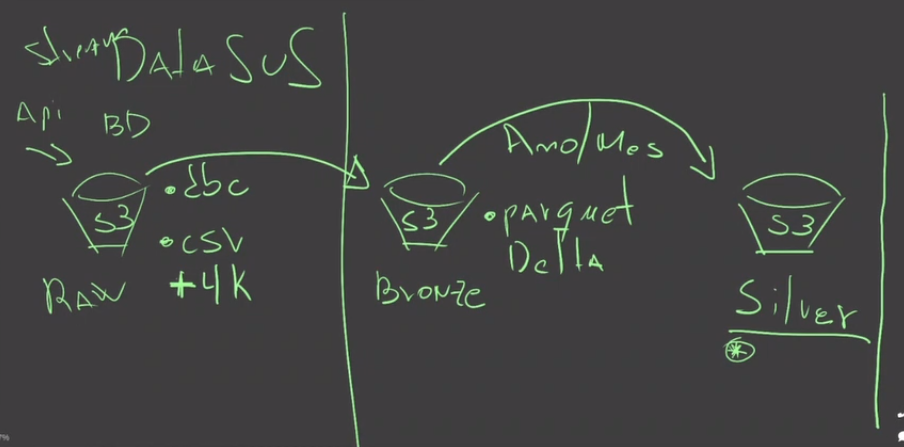

**Silver**: Transformar dados para que outros possam usar para analisar
 * desfecho da internação
 * sexo do paciente
 * idade

ideal: analistas trabalham com dados da Silver
Datasus: bronze está com códigos; não tem sentido para os pesquisadores

**Gold**: dimensão/métricas -> relatórios